<h1> Project 1 </h1>

<b> Group: </b> A <br>
<b> Members: </b>
- Francisco Parente (frvi@itu.dk) <br>
- Janusz Wilczek (jawi@itu.dk) <br>
- Julia Justyna Maziarz (jmaz@itu.dk) <br>
- Juraj Septak (juse@itu.dk) <br>
- Lukas Sarka (lsar@itu.dk) <br>

<b> Country: </b> Sweden

<h2> Task 0: Data filtering and cleaning </h2>

<b> Task description: </b> 

Out of the raw dataset, create a processed data set that contains only fields and records that are relevant to your analysis. You are going to use this processed data set for all the tasks below.

Briefly describe your data set in a numerical summary (e.g. number/meaning of fields and records, statistical key metrics). 

In [1]:
import pandas as pd

import folium, json

import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
import numpy as np
from   statsmodels.stats.multitest  import multipletests

from sklearn import linear_model
from statsmodels.regression.linear_model import OLS
import statsmodels as sm

from datetime import timedelta

<h3> Initial analysis and preparation of data </h3>

<b> WEATHER DATA </b>

In [2]:
'''Initial analysis of weather data'''
weather_data = pd.read_csv("../data/raw/weather/weather.csv", encoding = 'utf-8')
print('Shape: ',weather_data.shape) #checking the shape of the dataset
print('Empty cells: ',weather_data.isna().any().any()) #checking if the file has empty cells

'''Filtering the data valid for our country'''
weather_data = weather_data[weather_data['iso3166-2'].str.startswith('SE')]

'''Creating smaller datasets'''
weather_by_region = weather_data.groupby(by = 'iso3166-2').agg(['min','mean','median','max'])
weather_by_date = weather_data.groupby(by = 'date').agg(['mean'])

Shape:  (20220, 9)
Empty cells:  False


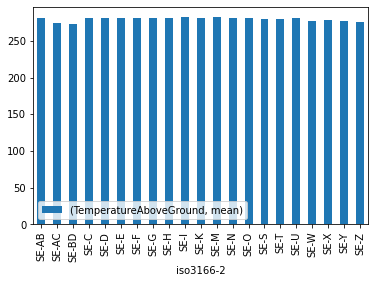

In [3]:
'''Plotting the mean temperature for every region'''
idx = pd.IndexSlice
weather_by_region.loc[:,idx['TemperatureAboveGround',:,:]].plot.bar(y = ('TemperatureAboveGround','mean')).legend(loc = 'lower left')

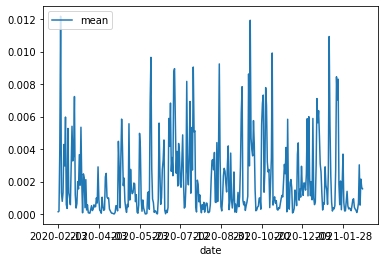

In [4]:
'''Plotting mean precipitation by date'''
weather_by_date.loc[:,'Totalprecipitation'].plot.line().legend(loc = 'upper left')

<b> COUNTRY DATA </b>

In [5]:
'''Importing the country metadata from a JSON file'''
with open('../data/raw/metadata/se_metadata.json', 'r', encoding = 'utf-8') as file:
    country_metadata = json.load(file)

'''Importing the shape of country for creating a map'''
with open('../data/raw/shapefiles/se.geojson', 'r', encoding = 'utf-8') as file:
    country_shape = json.load(file)

<b> COVID-19 DATA </b> (admissions)

In [34]:
'''Importing the data about hospitalizations due to COVID-19'''
corona_additions = pd.read_csv('../data/raw/corona/se_corona.csv', sep = '\t', encoding = 'utf-8')
print('Corona additions dataset shape: ', corona_additions.shape)
print('Empty cells: ',corona_additions.isna().any().any()) #checking if the file has empty cells

corona_additions

Corona additions dataset shape:  (8001, 3)
Empty cells:  False


,date,region_code,confirmed_addition
0,2021-02-18,Blekinge,23
1,2021-02-17,Blekinge,30
2,2021-02-16,Blekinge,50
3,2021-02-15,Blekinge,3
4,2021-02-14,Blekinge,3
...,...,...,...
7996,2020-02-08,Östergötland,0
7997,2020-02-07,Östergötland,0
7998,2020-02-06,Östergötland,0
7999,2020-02-05,Östergötland,0


In [33]:
'''Creating dataset of admissions per region for use for maps'''

'''Creating a dictionary of ISO codes of Swedish regions'''
isocodes_dictionary = {country_metadata['country_metadata'][i]['covid_region_code'] : country_metadata['country_metadata'][i]['iso3166-2_code'] for i in range(len(country_metadata['country_metadata']))}
corona_additions['iso3166-2'] = corona_additions['region_code'].map(isocodes_dictionary)
corona_additions_by_region = corona_additions.groupby(by = 'iso3166-2')['confirmed_addition'].sum().reset_index()

'''Creating a dictionary of ISO codes of regions and their population'''
isocode_population = {country_metadata['country_metadata'][i]['iso3166-2_code'] : country_metadata['country_metadata'][i]['population'] for i in range(len(country_metadata['country_metadata']))}
corona_additions_by_region['population'] = corona_additions_by_region['iso3166-2'].map(isocode_population)

corona_additions_by_region

,iso3166-2,confirmed_addition,population
0,SE-AB,149331,2377081
1,SE-AC,13205,271736
2,SE-BD,11640,250093
3,SE-C,23408,383713
4,SE-D,12638,297540
5,SE-E,21988,465495
6,SE-F,25319,363599
7,SE-G,13547,201469
8,SE-H,10801,245446
9,SE-I,2664,59686


<b> EXTERNAL DATA </b> (stringency index)

In [37]:
'''Loading the Our World in Data datases''' 
stringency_index = pd.read_csv("../data/external/owid-covid-data.csv")
print('Empty cells: ',stringency_index.isna().any().any())

'''Choosing only Sweden and dropping NAs'''
stringency_index = stringency_index[stringency_index["iso_code"] == "SWE"][["date", "stringency_index"]].dropna()
print('Empty cells after dropping NAs: ',stringency_index.isna().any().any())

stringency_index

Empty cells:  True
Empty cells after dropping NAs:  False


,date,stringency_index
140502,2020-02-01,5.56
140503,2020-02-02,5.56
140504,2020-02-03,5.56
140505,2020-02-04,5.56
140506,2020-02-05,5.56
...,...,...
141239,2022-02-07,50.00
141240,2022-02-08,50.00
141241,2022-02-09,19.44
141242,2022-02-10,19.44


<b> CREATING THE MAIN DATASET </b>

In [24]:
'''Merging weather data and admissions data'''
dataset = pd.merge(corona_additions,weather_data, on = ['iso3166-2','date'])

print('Lost rows from the weather data: ', weather_data.shape[0] - dataset.shape[0])
print('Lost rows from the admissions data: ', corona_additions.shape[0] - dataset.shape[0])


'''Adding stringency index'''
dataset = dataset.merge(stringency_index, on = "date") #regions have the strigency index on the same day

print('Main dataset shape: ', dataset.shape)

dataset

Lost rows from the weather data:  63
Lost rows from the admissions data:  189
Main dataset shape:  (7812, 12)


,date,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,stringency_index
0,2021-02-18,Blekinge,23,SE-K,91.958400,4.169385e+05,2.424771e+06,272.798250,0.000317,0.572565,4.132720,69.44
1,2021-02-18,Dalarna,78,SE-W,83.472412,5.560170e+05,2.327816e+06,266.825980,0.000902,0.000000,2.789497,69.44
2,2021-02-18,Gotland,3,SE-I,76.066474,1.217169e+06,2.449967e+06,269.751412,0.000011,2.044527,4.697774,69.44
3,2021-02-18,Gävleborg,234,SE-X,77.955185,1.722268e+06,2.383899e+06,267.193932,0.000124,0.000000,2.564518,69.44
4,2021-02-18,Halland,187,SE-N,91.276936,6.979065e+03,2.410299e+06,273.432810,0.000647,0.000000,4.960031,69.44
...,...,...,...,...,...,...,...,...,...,...,...,...
7807,2020-02-13,Västernorrland,0,SE-Y,83.230208,1.351595e+06,2.320155e+06,267.074790,0.000045,0.000000,1.497883,5.56
7808,2020-02-13,Västmanland,0,SE-U,71.129740,3.511075e+06,2.373874e+06,272.689054,0.000000,0.000000,2.593358,5.56
7809,2020-02-13,Västra_Götaland,0,SE-O,77.017705,3.841654e+06,2.370478e+06,274.449874,0.000039,0.792579,3.868366,5.56
7810,2020-02-13,Örebro,0,SE-T,69.266165,3.927441e+06,2.358019e+06,272.851181,0.000000,0.000000,3.391266,5.56


<h2> Task 1: Single variable analysis  </h2>

<b> Task description: </b> 

Report key statistics for the relevant variables you selected for your analysis (e.g. number of infected and temperature) for
1) the different country regions, and


2) in different levels of aggregation (daily, weekly, monthly).

<h2> Task 2: Associations  </h2>

<b> Task description: </b> 

Research whether there is a significant statistical association in your country between weather data and infection rates. Report whether there is a statistically significant association between your chosen variables or not, together with the appropriate statistical metric(s). Discuss why this association, or the lack of this association, is relevant for policies.

 <h2> Task 3: Map visualization  </h2>

<b> Task description: </b> 

Visualize a selection of important variables on a map of your country.

<h3> Visualizing the hospitalizations due to COVID-19 </h3>

In [ ]:
cases_map = folium.Map(location = [63,14], zoom_start = 4.13, crs = 'EPSG3857')

folium.Choropleth(
    geo_data = geo_json_path,
    name = 'Cases',
    data = corona_additions_by_region,
    columns = ['iso3166-2', 'confirmed_addition'],
    key_on = 'properties.iso_3166_2',
    fill_color = 'YlOrRd',
    fill_opacity = 0.5,
    line_opacity = 0.3,
    legend_name = 'Admitted',
).add_to(cases_map)

cases_map

<h3> Visualizing the hospitalizations due to COVID-19 per capita</h3>

In [ ]:
corona_additions_by_region['admitted_per_capita'] = corona_additions_by_region['confirmed_addition'] / corona_additions_by_region['population'] 
  
cases_map = folium.Map(location = [63,14], zoom_start = 4, crs = 'EPSG3857')

folium.Choropleth(
    geo_data = geo_json_path,
    name = 'Cases',
    data = corona_additions_by_region,
    columns = ['iso3166-2', 'admitted_per_capita'],
    key_on = 'properties.iso_3166_2',
    fill_color = 'YlGn',
    fill_opacity = 0.5,
    line_opacity = 0.3,
    legend_name = 'Admitted per capita',
).add_to(cases_map)

cases_map

 <h2> Task 4: Open question  </h2>

<b> Task description: </b> 

Use the data to formulate, motivate, answer, and discuss another research question of your choice. For example, compare your country to another one in the dataset; or investigate additional variables that you could find elsewhere (e.g. total population, population density, population demographics such as age distribution, number of elders, etc); or identify if there are temporal patterns (is one variable more important in some months? Are weekends different from weekdays? Etc), ...

<h3> Comparing Sweden to Denmark </h3>